In [53]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data

### Read In Edge List and Transpose into COO Format

In [54]:
with open('edge_list/edge_index.txt') as edge_file:
    edges = []
    for line in edge_file.readlines():
        u, v, d = line.split()
        edges.append([int(u),int(v)])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

### Read in Data Matrix and Convert to Torch Tensor

$n x m$ matrix where $n$ is the number of states and $m$ is the number of search terms(features).

In [55]:
!ls hopkins_data/cleaned

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [56]:
nodes_props = np.loadtxt('./datesprepped/2020-01-31.csv')
nodes_props

array([[ 0.,  0.,  0., ...,  0., 11.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 14.,  0., ...,  0., 10.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Get Hopkins Data Labels

In [57]:
# y = np.round(np.random.random(size=[51,1]) * 10) # randomly generate some cases for now
# y = torch.tensor(y, dtype=torch.float)
with open('./hopkins_data/cleaned/2020-01-31.csv') as fy:
    y_arr = [int(line.split(',')[0]) for line in fy.readlines()]
y = torch.tensor(y_arr, dtype=torch.float).reshape([51, 1])

### Create Data Object

In [58]:
x = torch.tensor(nodes_props.tolist(), dtype=torch.float)
edge_index = edge_index
data = Data(x=x, y=y, edge_index=edge_index)

In [59]:
data.num_node_features

3243

### Creating Dataloader

Now that we've created a single data object as an example we need to create a torch dataloader. This way we can batch multiple nodes together.

In [60]:
import os.path as osp
from datetime import datetime, timedelta
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader


class COVIDSearchTerms(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(COVIDSearchTerms, self).__init__(root, transform, pre_transform)
        self.node_files = []
        self.target_files = []

    @property
    def raw_file_names(self):
        self.node_files = ['x/' + f for f in os.listdir('raw/x/')]
        self.node_files.sort(
            key = lambda date: datetime.strptime(date.split('/')[-1].split('.')[0], '%Y-%m-%d')
        )
        # ensure that we only grab targets for dates we have
        self.target_files = [
            'y/' + f for f in
            list(set(os.listdir('raw/y/')) & set(os.listdir('raw/x/')))
        ]

        self.target_files.sort(
            key = lambda date: datetime.strptime(date.split('/')[-1].split('.')[0], '%Y-%m-%d')
        )

        return self.node_files + self.target_files

    @property
    def processed_file_names(self):
        dates = os.listdir('raw/y/')
        return dates

    def download(self):
        pass
        # Download to `self.raw_dir`.

    def process(self):
        with open('edge_list/edge_index.txt') as edge_file:
            edges = []
            for line in edge_file.readlines():
                u, v, d = line.split()
                edges.append([int(u),int(v)])
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        
        i = 0
        for node_file in self.node_files:
            date = node_file.split('/')[-1].split('.')[0]
            week_forward = datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=1)
            x = torch.tensor(np.loadtxt('raw/' + node_file).tolist(), dtype=torch.float)
            
            with open('raw/y/' + date + '.csv') as fy:
                hk_data_arr = [int(line.split(',')[0]) for line in fy.readlines()]
            hk_data_arr = torch.tensor(hk_data_arr, dtype=torch.float).reshape([51, 1])
            
            x = torch.cat([x, hk_data_arr], dim=1)
            
            with open('raw/y/' + week_forward.strftime('%Y-%m-%d') + '.csv') as fy:
                y_arr = [int(line.split(',')[0]) for line in fy.readlines()]
            y = torch.tensor(y_arr, dtype=torch.float).reshape([1, 51])
            edge_index = edge_index
            # Read data from `raw_path`.
            data = Data(x=x, y=y, edge_index=edge_index)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)
            torch.save(data, osp.join(self.processed_dir, 'data-{}.pt'.format(i)))
            i = i + 1

    def len(self):
        return 57

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data-{}.pt'.format(idx)))
        return data

### Example Network Structure

In [61]:
'''
    Network structure taken from example:
    https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
'''

feature_dim = data.num_node_features # should be 3243 for the number of queries
from torch.nn import LSTM
from torch_geometric.nn import TopKPooling, SAGEConv, GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 6 layers down convolutons?
        self.conv1 = GCNConv(feature_dim + 1, 2000)
        self.conv2 = GCNConv(2000, 1000)
        self.conv3 = GCNConv(1000, 500)
        self.conv4 = GCNConv(500, 100)
        self.conv5 = GCNConv(100, 10)
        # Reveals a [51, 1] tensor where the 2nd dimensions is the number of cases?
        self.conv6 = GCNConv(10, 1)
        
#         self.lin1 = torch.nn.Linear(10, 51)
#         self.act1 = torch.nn.ReLU()
        
#         self.lstm = LSTM(input_size=51, hidden_size=51, num_layers=3)
        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        nm = torch.norm(x).detach()
        x = x.div(nm.expand_as(x))
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv6(x, edge_index)
        
#         x = self.lin1(x)
#         x = self.act1(x)

#         x, _ = self.lstm(x.view(1, 51, 51))
        
        return x.t()

### Example feed forward of the network

In [62]:
def train():
    model.train()

    losses = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        print(loss)
        losses.append(loss)
        loss.backward()
#         loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return losses

batch_size=1
dataset = COVIDSearchTerms('.')
trainset, valid_data = dataset[:50], dataset[50:]
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.L1Loss()
train_loader = DataLoader(trainset, batch_size=batch_size)


losses = []
i = 1
for epoch in range(5):
    losses.append(train())
    print((i / 10) * 100)
    i = i + 1

Processing...
Done!
tensor(0.2387, grad_fn=<L1LossBackward>)
tensor(0.3211, grad_fn=<L1LossBackward>)
tensor(0.6236, grad_fn=<L1LossBackward>)
tensor(0.4115, grad_fn=<L1LossBackward>)
tensor(0.3164, grad_fn=<L1LossBackward>)
tensor(0.2988, grad_fn=<L1LossBackward>)
tensor(0.3723, grad_fn=<L1LossBackward>)
tensor(0.3214, grad_fn=<L1LossBackward>)
tensor(0.3456, grad_fn=<L1LossBackward>)
tensor(0.6885, grad_fn=<L1LossBackward>)
tensor(0.6873, grad_fn=<L1LossBackward>)
tensor(0.6895, grad_fn=<L1LossBackward>)
tensor(0.3582, grad_fn=<L1LossBackward>)
tensor(0.3478, grad_fn=<L1LossBackward>)
tensor(0.3347, grad_fn=<L1LossBackward>)
tensor(0.3861, grad_fn=<L1LossBackward>)
tensor(0.3545, grad_fn=<L1LossBackward>)
tensor(0.5189, grad_fn=<L1LossBackward>)
tensor(0.6279, grad_fn=<L1LossBackward>)
tensor(1.0994, grad_fn=<L1LossBackward>)
tensor(1.5546, grad_fn=<L1LossBackward>)
tensor(2.1573, grad_fn=<L1LossBackward>)
tensor(3.4903, grad_fn=<L1LossBackward>)
tensor(4.6280, grad_fn=<L1LossBackwar

tensor(3682.9395, grad_fn=<L1LossBackward>)
tensor(4176.4595, grad_fn=<L1LossBackward>)
tensor(4768.9463, grad_fn=<L1LossBackward>)
40.0
tensor(0.4302, grad_fn=<L1LossBackward>)
tensor(0.4336, grad_fn=<L1LossBackward>)
tensor(0.4846, grad_fn=<L1LossBackward>)
tensor(0.4868, grad_fn=<L1LossBackward>)
tensor(0.4882, grad_fn=<L1LossBackward>)
tensor(0.4892, grad_fn=<L1LossBackward>)
tensor(0.4898, grad_fn=<L1LossBackward>)
tensor(0.4899, grad_fn=<L1LossBackward>)
tensor(0.4898, grad_fn=<L1LossBackward>)
tensor(0.8709, grad_fn=<L1LossBackward>)
tensor(0.8702, grad_fn=<L1LossBackward>)
tensor(0.8693, grad_fn=<L1LossBackward>)
tensor(0.5257, grad_fn=<L1LossBackward>)
tensor(0.5239, grad_fn=<L1LossBackward>)
tensor(0.5227, grad_fn=<L1LossBackward>)
tensor(0.5406, grad_fn=<L1LossBackward>)
tensor(0.5387, grad_fn=<L1LossBackward>)
tensor(0.6836, grad_fn=<L1LossBackward>)
tensor(0.7894, grad_fn=<L1LossBackward>)
tensor(1.2289, grad_fn=<L1LossBackward>)
tensor(1.6591, grad_fn=<L1LossBackward>)
te

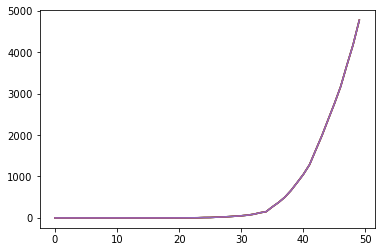

In [63]:
import matplotlib.pyplot as plt

for i in losses:
    plt.plot(i)

In [91]:
valid_data = dataset[50:]
validation_loader = DataLoader(valid_data, batch_size=batch_size)
state_names = []
a_file = open("./states_and_abbreviations.txt", "r")
for line in a_file:
  stripped_line = line.strip()
  line_list = stripped_line.split()
  state_names.append(line_list)

def Sort_Tuple(tup):  
  
    # reverse = None (Sorts in Ascending order)  
    # key is set to sort using second element of  
    # sublist lambda has been used  
    tup.sort(key = lambda x: x[1].item(), reverse=True)  
    return tup  

for data in validation_loader:
    output = model(data)
    label = data.y.to(device)
    output_with_state = []
    label_with_state = []
    for i, state in enumerate(state_names):
        output_with_state.append((state, output[0][i]))
    
    for i, state in enumerate(state_names):
        label_with_state.append((state, label[0][i]))
    

    print('OUTPUT:')
    print(Sort_Tuple(output_with_state))
    print('LABEL:')
    print(Sort_Tuple(label_with_state))
    print()

0.3046489655971527
1495.0
OUTPUT:
[(['Alabama,AL'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Alaska,AK'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Arizona,AZ'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Arkansas,AR'], tensor(0.3046, grad_fn=<SelectBackward>)), (['California,CA'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Colorado,CO'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Connecticut,CT'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Delaware,DE'], tensor(0.3046, grad_fn=<SelectBackward>)), (['District', 'of', 'Columbia,', 'DC'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Florida,FL'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Georgia,GA'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Hawaii,HI'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Idaho,ID'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Illinois,IL'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Indiana,IN'], tensor(0.3046, grad_fn=<SelectBackward>)), (['Iowa,IA'], tensor(0.3046, grad_f

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

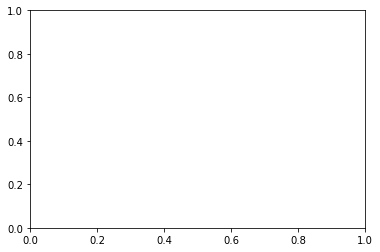

### Old training example

In [29]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.MSELoss()


# Fit?
model.train()

for i in range(0,500):
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data)
    label = data.y.to(device)
    loss = crit(output, label)
    print(loss)
    loss.backward()
    loss_all = loss.item()
    optimizer.step()

optimizer.zero_grad()
output = model(data)
loss = crit(output, label)
print(output)
print(loss)

AttributeError: 'Data' object has no attribute 'batch'

In [ ]:
'''
    Network structure taken from example:
    https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8
'''

feature_dim = data.num_node_features # should be 3243 for the number of queries
from torch_geometric.nn import TopKPooling, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Replaced all instances of the dim 128 with 1500
        self.conv1 = SAGEConv(feature_dim + 1, 1000)
        self.pool1 = TopKPooling(1000, ratio=0.8)
        self.conv2 = SAGEConv(1000, 1000)
        self.pool2 = TopKPooling(1000, ratio=0.8)
        self.conv3 = SAGEConv(1000, 1000)
        self.pool3 = TopKPooling(1000, ratio=0.8)
# We kind of did our own embeddings....
#         self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(2000, 1000)
#         self.lin1 = torch.nn.Linear(feature_dim, 1500)
        self.lin2 = torch.nn.Linear(1000, 500)
        self.lin3 = torch.nn.Linear(500, 250)
        self.lin4 = torch.nn.Linear(250, 51)
#         self.bn1 = torch.nn.BatchNorm1d(500)
#         self.bn2 = torch.nn.BatchNorm1d(125)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()
        self.act3 = torch.nn.ReLU()
        self.act4 = torch.nn.ReLU()
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
    
        x = F.relu(self.conv1(x, edge_index))

        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3
        
        x = self.lin1(x)
        x = self.act1(x)        
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)
        # Using the third layer in a traditional sense?
        x = self.lin3(x)
        x = self.act3(x)
        x = self.lin4(x)
        x = self.act4(x)
        # We need to change the ouput to continous rather than discrete
#         x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

### Example work for earlier session with torch geo

In [ ]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [ ]:
data = Data(x=x, edge_index=edge_index, y=y)

In [ ]:
data.num_node_features

In [ ]:
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(2, 1)
        self.lin1 = torch.nn.Linear(1, 1)
        self.act1 = torch.nn.ReLU()
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index))
        x = self.lin1(x)
        x = self.act1(x)
        return x
        

In [ ]:
device = torch.device('cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.MSELoss()


# Fit?
model.train()

for i in range(0,1000):
    data = data.to(device)
    optimizer.zero_grad()
    output = model(data)
    print(output, loss)
    label = data.y.to(device)
    loss = crit(output, label)
    loss.backward()
    loss_all = loss.item()
    optimizer.step()

optimizer.zero_grad()
output = model(data)
loss = crit(output, label)
print(output)
print(loss)